In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr


from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco


from netCDF4 import Dataset

import seawater

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import derive_potential_density_values_TEST
from analysis_package import ecco_masks

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [66]:
"""
made this script to interpolate potential density horizontally..

"""
######################################################################################################################
################################## DEFINE DATA FILES AND THEIR ASSOCIATED PATHS ######################################
######################################################################################################################

# complete_data_dir contains ECCO state data over the entire dataset time range 
# (1992-2016, 288 monthly mean time steps)
complete_data_dir = "./nctiles_monthly/"
# dem_dir conatins ECCO state data truncated to the first 12 monthly mean time steps
demo_dir = "./demo_nctiles_monthly/"
data_dir = complete_data_dir

# PDENS: Potential density at sigma 2
PDENS_var_str = "PDENS"

######################################################################################################################
############################################ DEFINE TIMESLICE ########################################################
######################################################################################################################

time_slice = np.arange(0,288)
        
    
######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################

grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)


######################################################################################################################
################################## CALCULATE POTENTIAL DENSITY #######################################################
######################################################################################################################

# calculate potential density and in situ pressure
PDENS_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,PDENS_var_str,time_slice,rename_indices=False)
# set data file indecies starting from zero.
PDENS_ds = PDENS_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice)


Loaded PDENS over time slice  



<module 'matplotlib.pyplot' from '/Users/Tatsu1/anaconda2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

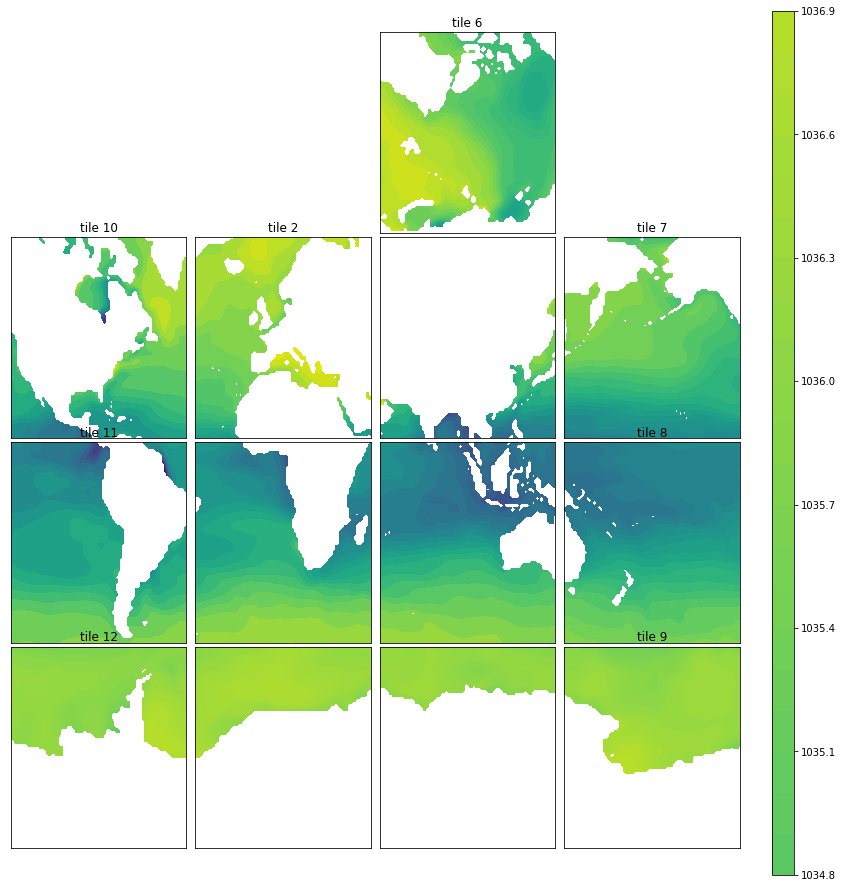

In [67]:
plotting_functions.world_plot(PDENS_ds.PDENS.isel(time=1,k=0))

In [68]:
PDENS_ds_Test = PDENS_ds.copy(deep=True) > 0
PDENS_ds_Test.load()
PDENS_ds_prototype = PDENS_ds_Test.load()*0
for tile in range(0,13):
    PDENS_ds_prototype.PDENS.loc[{"tile":tile}] = PDENS_ds_Test.PDENS.isel(tile=tile)*(tile+1)



<module 'matplotlib.pyplot' from '/Users/Tatsu1/anaconda2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

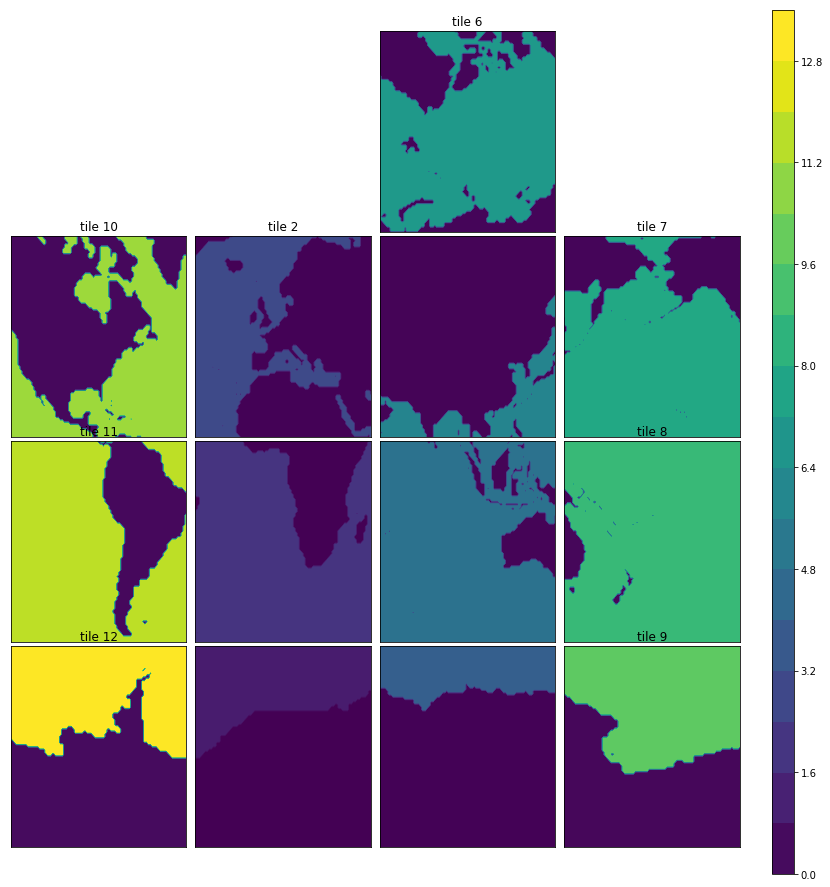

In [69]:
plotting_functions.world_plot(PDENS_ds_prototype.PDENS.isel(time=0,k=0))


<module 'matplotlib.pyplot' from '/Users/Tatsu1/anaconda2/lib/python3.6/site-packages/matplotlib/pyplot.py'>

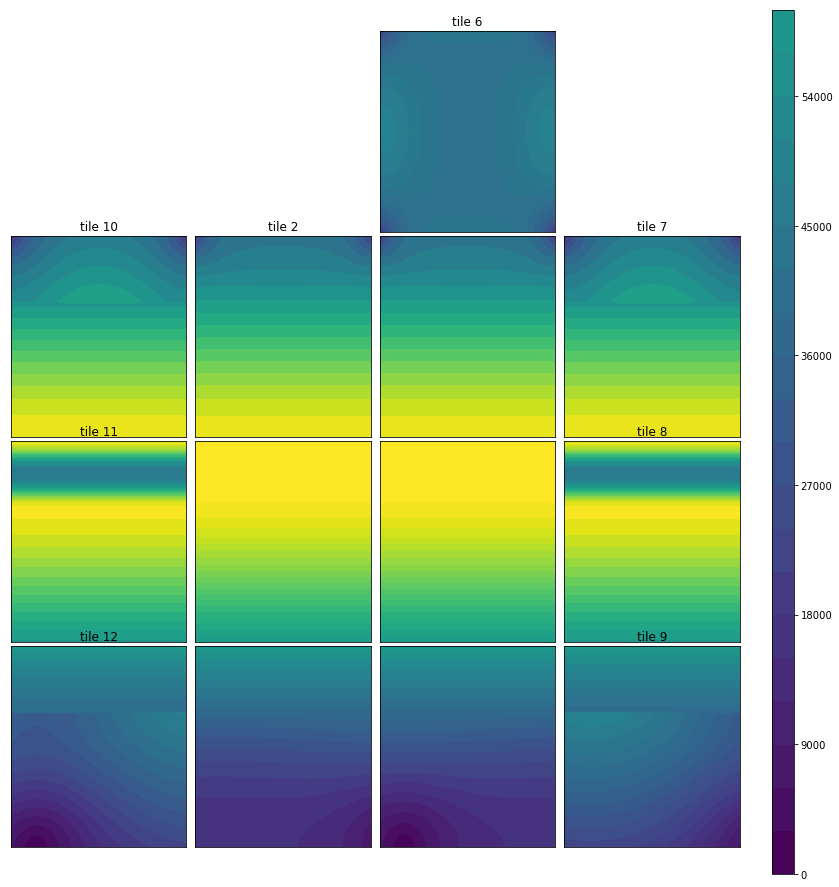

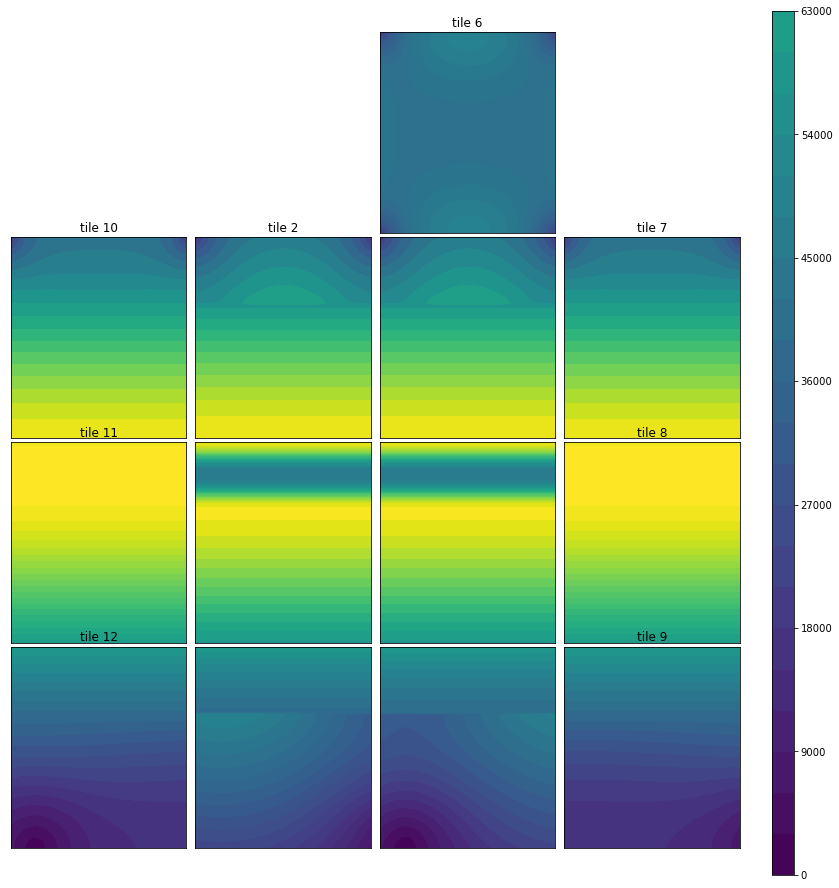

In [70]:
plotting_functions.world_plot(grid.dxG)
plotting_functions.world_plot(grid.dyG)

In [71]:
print(grid.dyG.isel(tile=0,j=slice(0,40)).values.shape)

(40, 90)


In [72]:
def interpolate_c_to_v(data_array,grid):
    # need to interpolate between c values and corresponding values shifted downwards one cell unit
    # in the v direction
    print("checkpoint 1")
    interpolated_v_data = data_array.copy(deep=True)
    j_distance_between_c_points = data_array.copy(deep=True)
    
    print("checkpoint 2")
    interpolated_v_data.loc[{"tile":0}] = data_array.isel(tile=0) - np.concatenate((data_array.isel(tile=0,j=slice(89,90)).values*0,data_array.isel(tile=0,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":1}] = data_array.isel(tile=1) - np.concatenate((data_array.isel(tile=0,j=slice(89,90)).values,data_array.isel(tile=1,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":2}] = data_array.isel(tile=2) - np.concatenate((data_array.isel(tile=1,j=slice(89,90)).values,data_array.isel(tile=2,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":3}] = data_array.isel(tile=3) - np.concatenate((data_array.isel(tile=3,j=slice(89,90)).values*0,data_array.isel(tile=3,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":4}] = data_array.isel(tile=4) - np.concatenate((data_array.isel(tile=3,j=slice(89,90)).values,data_array.isel(tile=4,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":5}] = data_array.isel(tile=5) - np.concatenate((data_array.isel(tile=4,j=slice(89,90)).values,data_array.isel(tile=5,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":6}] = data_array.isel(tile=6) - np.concatenate((data_array.isel(tile=5,j=slice(89,90)).values,data_array.isel(tile=6,j=slice(0,89)).values),axis=2) 
    interpolated_v_data.loc[{"tile":7}] = data_array.isel(tile=7) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=5,i=slice(89,90)).values,axis=2),axes=[0,1,3,2]),data_array.isel(tile=7,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":8}] = data_array.isel(tile=8) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=4,i=slice(89,90)).values,axis=2),axes=[0,1,3,2]),data_array.isel(tile=8,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":9}] = data_array.isel(tile=9) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=3,i=slice(89,90)).values,axis=2),axes=[0,1,3,2]),data_array.isel(tile=9,j=slice(0,89)).values),axis=2)            
    interpolated_v_data.loc[{"tile":10}] = data_array.isel(tile=10) - np.concatenate((data_array.isel(tile=7,j=slice(89,90)).values,data_array.isel(tile=10,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":11}] = data_array.isel(tile=11) - np.concatenate((data_array.isel(tile=8,j=slice(89,90)).values,data_array.isel(tile=11,j=slice(0,89)).values),axis=2)    
    interpolated_v_data.loc[{"tile":12}] = data_array.isel(tile=12) - np.concatenate((data_array.isel(tile=9,j=slice(89,90)).values,data_array.isel(tile=12,j=slice(0,89)).values),axis=2)    
    
    print("checkpoint 3")
    j_distance_between_c_points.loc[{"tile":0}] = (grid.dyG.isel(tile=0) + np.concatenate((grid.dyG.isel(tile=0,j=slice(89,90)).values*0,grid.dyG.isel(tile=0,j=slice(0,89)).values),axis=0))/2.  
    j_distance_between_c_points.loc[{"tile":1}] = (grid.dyG.isel(tile=1) + np.concatenate((grid.dyG.isel(tile=0,j=slice(89,90)).values,grid.dyG.isel(tile=1,j=slice(0,89)).values),axis=0))/2.    
    j_distance_between_c_points.loc[{"tile":2}] = (grid.dyG.isel(tile=2) + np.concatenate((grid.dyG.isel(tile=1,j=slice(89,90)).values,grid.dyG.isel(tile=2,j=slice(0,89)).values),axis=0))/2.        
    j_distance_between_c_points.loc[{"tile":3}] = (grid.dyG.isel(tile=3) + np.concatenate((grid.dyG.isel(tile=3,j=slice(89,90)).values*0,grid.dyG.isel(tile=3,j=slice(0,89)).values),axis=0))/2.    
    j_distance_between_c_points.loc[{"tile":4}] = (grid.dyG.isel(tile=4) + np.concatenate((grid.dyG.isel(tile=3,j=slice(89,90)).values,grid.dyG.isel(tile=4,j=slice(0,89)).values),axis=0))/2.    
    j_distance_between_c_points.loc[{"tile":5}] = (grid.dyG.isel(tile=5) + np.concatenate((grid.dyG.isel(tile=4,j=slice(89,90)).values,grid.dyG.isel(tile=5,j=slice(0,89)).values),axis=0))/2.    
    j_distance_between_c_points.loc[{"tile":6}] = (grid.dyG.isel(tile=6) + np.concatenate((grid.dyG.isel(tile=5,j=slice(89,90)).values,grid.dyG.isel(tile=6,j=slice(0,89)).values),axis=0))/2.   
    j_distance_between_c_points.loc[{"tile":7}] = (grid.dyG.isel(tile=7) + np.concatenate((np.transpose(np.flip(grid.dyG.isel(tile=5,i_g=slice(89,90)).values,axis=0),axes=[1,0]),grid.dyG.isel(tile=7,j=slice(0,89)).values),axis=0))/2.    
    j_distance_between_c_points.loc[{"tile":8}] = (grid.dyG.isel(tile=8) + np.concatenate((np.transpose(np.flip(grid.dyG.isel(tile=4,i_g=slice(89,90)).values,axis=0),axes=[1,0]),grid.dyG.isel(tile=8,j=slice(0,89)).values),axis=0))/2.    
    j_distance_between_c_points.loc[{"tile":9}] = (grid.dyG.isel(tile=9) + np.concatenate((np.transpose(np.flip(grid.dyG.isel(tile=3,i_g=slice(89,90)).values,axis=0),axes=[1,0]),grid.dyG.isel(tile=9,j=slice(0,89)).values),axis=0))/2.        
    j_distance_between_c_points.loc[{"tile":10}] = (grid.dyG.isel(tile=10) + np.concatenate((grid.dyG.isel(tile=7,j=slice(89,90)).values,grid.dyG.isel(tile=10,j=slice(0,89)).values),axis=0))/2.   
    j_distance_between_c_points.loc[{"tile":11}] = (grid.dyG.isel(tile=11) + np.concatenate((grid.dyG.isel(tile=8,j=slice(89,90)).values,grid.dyG.isel(tile=11,j=slice(0,89)).values),axis=0))/2.   
    j_distance_between_c_points.loc[{"tile":12}] = (grid.dyG.isel(tile=12) + np.concatenate((grid.dyG.isel(tile=9,j=slice(89,90)).values,grid.dyG.isel(tile=12,j=slice(0,89)).values),axis=0))/2.    
    
    print("checkpoint 4")
    data_slope_between_c_points = interpolated_v_data.rename({"j":"j_g"})/j_distance_between_c_points.rename({"j":"j_g"})
    print("checkpoint 5")
    data_at_v_points = data_slope_between_c_points*grid.dyG.rename({"j":"j_g","i_g":"i"})/2 + data_array.rename({"j":"j_g"})
    
    return data_at_v_points, data_slope_between_c_points, j_distance_between_c_points



def interpolate_c_to_u(data_array,grid):
    # need to interpolate between c values and corresponding values shifted downwards one cell unit
    # in the v direction
    print("checkpoint 1")
    interpolated_u_data = data_array.copy(deep=True)
    i_distance_between_c_points = data_array.copy(deep=True)*0
    
    print("checkpoint 2")
    interpolated_u_data.loc[{"tile":0}] = data_array.isel(tile=0) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=12,j=slice(89,90)).values,axis=3),axes=[0,1,3,2]),data_array.isel(tile=0,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":1}] = data_array.isel(tile=1) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=11,j=slice(89,90)).values,axis=3),axes=[0,1,3,2]),data_array.isel(tile=1,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":2}] = data_array.isel(tile=2) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=10,j=slice(89,90)).values,axis=3),axes=[0,1,3,2]),data_array.isel(tile=2,i=slice(0,89)).values),axis=3) 
    interpolated_u_data.loc[{"tile":3}] = data_array.isel(tile=3) - np.concatenate((data_array.isel(tile=0,i=slice(89,90)).values,data_array.isel(tile=3,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":4}] = data_array.isel(tile=4) - np.concatenate((data_array.isel(tile=1,i=slice(89,90)).values,data_array.isel(tile=4,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":5}] = data_array.isel(tile=5) - np.concatenate((data_array.isel(tile=2,i=slice(89,90)).values,data_array.isel(tile=5,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":6}] = data_array.isel(tile=6) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=2,j=slice(89,90)).values,axis=3),axes=[0,1,3,2]),data_array.isel(tile=6,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":7}] = data_array.isel(tile=7) - np.concatenate((data_array.isel(tile=6,i=slice(89,90)).values,data_array.isel(tile=7,i=slice(0,89)).values),axis=3)     
    interpolated_u_data.loc[{"tile":8}] = data_array.isel(tile=8) - np.concatenate((data_array.isel(tile=7,i=slice(89,90)).values,data_array.isel(tile=8,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":9}] = data_array.isel(tile=9) - np.concatenate((data_array.isel(tile=8,i=slice(89,90)).values,data_array.isel(tile=9,i=slice(0,89)).values),axis=3)
    interpolated_u_data.loc[{"tile":10}] = data_array.isel(tile=10) - np.concatenate((np.transpose(np.flip(data_array.isel(tile=6,j=slice(89,90)).values,axis=3),axes=[0,1,3,2]),data_array.isel(tile=10,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":11}] = data_array.isel(tile=11) - np.concatenate((data_array.isel(tile=10,i=slice(89,90)).values,data_array.isel(tile=11,i=slice(0,89)).values),axis=3)    
    interpolated_u_data.loc[{"tile":12}] = data_array.isel(tile=12) - np.concatenate((data_array.isel(tile=11,i=slice(89,90)).values,data_array.isel(tile=12,i=slice(0,89)).values),axis=3)    
    
    print("checkpoint 3")
    i_distance_between_c_points.loc[{"tile":0}] = (grid.dxG.isel(tile=0) + np.concatenate((np.transpose(np.flip(grid.dxG.isel(tile=12,j_g=slice(89,90)).values,axis=1),axes=[1,0]),grid.dxG.isel(tile=0,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":1}] = (grid.dxG.isel(tile=1) + np.concatenate((np.transpose(np.flip(grid.dxG.isel(tile=11,j_g=slice(89,90)).values,axis=1),axes=[1,0]),grid.dxG.isel(tile=1,i=slice(0,89)).values),axis=1))/2.   
    i_distance_between_c_points.loc[{"tile":2}] = (grid.dxG.isel(tile=2) + np.concatenate((np.transpose(np.flip(grid.dxG.isel(tile=10,j_g=slice(89,90)).values,axis=1),axes=[1,0]),grid.dxG.isel(tile=2,i=slice(0,89)).values),axis=1))/2. 
    i_distance_between_c_points.loc[{"tile":3}] = (grid.dxG.isel(tile=3) + np.concatenate((grid.dxG.isel(tile=0,i=slice(89,90)).values,grid.dxG.isel(tile=3,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":4}] = (grid.dxG.isel(tile=4) + np.concatenate((grid.dxG.isel(tile=1,i=slice(89,90)).values,grid.dxG.isel(tile=4,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":5}] = (grid.dxG.isel(tile=5) + np.concatenate((grid.dxG.isel(tile=2,i=slice(89,90)).values,grid.dxG.isel(tile=5,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":6}] = (grid.dxG.isel(tile=6) + np.concatenate((np.transpose(np.flip(grid.dxG.isel(tile=2,j_g=slice(89,90)).values,axis=1),axes=[1,0]),grid.dxG.isel(tile=6,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":7}] = (grid.dxG.isel(tile=7) + np.concatenate((grid.dxG.isel(tile=6,i=slice(89,90)).values,grid.dxG.isel(tile=7,i=slice(0,89)).values),axis=1))/2.     
    i_distance_between_c_points.loc[{"tile":8}] = (grid.dxG.isel(tile=8) + np.concatenate((grid.dxG.isel(tile=7,i=slice(89,90)).values,grid.dxG.isel(tile=8,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":9}] = (grid.dxG.isel(tile=9) + np.concatenate((grid.dxG.isel(tile=8,i=slice(89,90)).values,grid.dxG.isel(tile=9,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":10}] = (grid.dxG.isel(tile=10) + np.concatenate((np.transpose(np.flip(grid.dxG.isel(tile=6,j_g=slice(89,90)).values,axis=1),axes=[1,0]),grid.dxG.isel(tile=10,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":11}] = (grid.dxG.isel(tile=11) + np.concatenate((grid.dxG.isel(tile=10,i=slice(89,90)).values,grid.dxG.isel(tile=11,i=slice(0,89)).values),axis=1))/2.    
    i_distance_between_c_points.loc[{"tile":12}] = (grid.dxG.isel(tile=12) + np.concatenate((grid.dxG.isel(tile=11,i=slice(89,90)).values,grid.dxG.isel(tile=12,i=slice(0,89)).values),axis=1))/2.       

    print("checkpoint 4")
    data_slope_between_c_points = interpolated_u_data.rename({"i":"i_g"})/i_distance_between_c_points.rename({"i":"i_g"})
    print("checkpoint 5")
    data_at_u_points = data_slope_between_c_points*grid.dxG.rename({"j_g":"j","i":"i_g"})/2. + data_array.rename({"i":"i_g"})
    
    
    return data_at_u_points, data_slope_between_c_points, i_distance_between_c_points

# grid.dxG.dims = ('tile', 'j_g', 'i')
# grid.dyG.dims = ('tile', 'j', 'i_g')


In [73]:
print(grid.dxG)

<xarray.DataArray 'dxG' (tile: 13, j_g: 90, i: 90)>
array([[[  15584.907227,   15589.316406, ...,    7446.051758,    7004.152832],
        [  15588.651367,   15593.047852, ...,    7461.828613,    7021.133301],
        ..., 
        [  58813.304688,   58813.304688, ...,   58813.304688,   58813.304688],
        [  59676.609375,   59676.609375, ...,   59676.609375,   59676.609375]],

       [[  60542.324219,   60542.324219, ...,   60542.324219,   60542.324219],
        [  61409.804688,   61409.804688, ...,   61409.804688,   61409.804688],
        ..., 
        [ 110084.703125,  110084.703125, ...,  110084.703125,  110084.703125],
        [ 109809.445312,  109809.445312, ...,  109809.445312,  109809.445312]],

       ..., 
       [[ 108086.078125,  106469.65625 , ...,   59953.410156,   59441.125   ],
        [ 108086.078125,  106469.65625 , ...,   59953.410156,   59441.125   ],
        ..., 
        [ 108086.078125,  106469.65625 , ...,   59953.410156,   59441.125   ],
        [ 108086.078

In [ ]:
pdens_v = interpolate_c_to_v(PDENS_ds.PDENS,grid)
pdens_u = interpolate_c_to_u(PDENS_ds.PDENS,grid)

checkpoint 1
checkpoint 2
checkpoint 3
checkpoint 4
checkpoint 5
checkpoint 1
checkpoint 2
checkpoint 3
checkpoint 4
checkpoint 5


In [ ]:
k = 1
time = 1
tile = 10
j_g_slice = slice(0,5)
i_g_slice = slice(0,5)

plt.figure(figsize=(20,10))
plt.contourf(pdens_v[2].isel(k=k,time=time,tile=tile,j=j_g_slice,i=i_g_slice))
plt.title("distance between grid centers")
plt.colorbar()
plt.grid()
plt.show()
plt.close()

plt.figure(figsize=(20,10))
plt.contourf(grid.dyG.isel(tile=tile,j=j_g_slice,i_g=i_g_slice))
plt.title("dyG")
plt.grid()
plt.colorbar()
plt.show()
plt.close()

In [ ]:
print("v interpolation distance")
print(pdens_v[2].isel(k=k,time=time,tile=tile,j=j_g_slice,i=i_g_slice).values,"\n\n")
print("grid dyG")
print(np.rint(grid.dyG.isel(tile=tile,j=j_g_slice,i_g=i_g_slice).values))
print("\n\n\n")
print("u interpolation distance")
print(pdens_u[2].isel(k=k,time=time,tile=tile,j=j_g_slice,i=i_g_slice).values,"\n\n")
print("grid dxG")
print(np.rint(grid.dxG.isel(tile=tile,j_g=j_g_slice,i=i_g_slice).values))

In [ ]:
pdens_u = interpolate_c_to_u(PDENS_ds.PDENS,grid)

In [ ]:
plotting_functions.world_plot(pdens_v[0].isel(k=1,time=1))

In [ ]:
plotting_functions.world_plot(pdens_u[0].isel(k=1,time=1))

In [ ]:
print(pdens_u[0])
print("\n\n\n\n")
print(pdens_v[0])

In [ ]:
PDENS_ds_u = PDENS_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice).copy(deep=True).rename({"i":"i_g"})

PDENS_ds_v = PDENS_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice).copy(deep=True).rename({"j":"j_g"})


In [ ]:
print(PDENS_ds_u.PDENS)

In [ ]:
PDENS_ds_u["PDENS"] = pdens_u[0]
PDENS_ds_v["PDENS"] = pdens_v[0]

In [ ]:
plotting_functions.world_plot(PDENS_ds_u["PDENS"].isel(k=1,time=1))

In [ ]:
tiles = np.arange(0,13)
tile_data_dir = "./nctiles_monthly/"
for tile in tiles:
    if tile < 9:
        pass
        PDENS_ds_u.isel(tile=tile).to_netcdf(tile_data_dir+"PDENS_U/PDENS_U.000"+str(tile+1)+".nc")
        PDENS_ds_v.isel(tile=tile).to_netcdf(tile_data_dir+"PDENS_V/PDENS_V.000"+str(tile+1)+".nc")
    else:
        pass
        PDENS_ds_u.isel(tile=tile).to_netcdf(tile_data_dir+"PDENS_U/PDENS_U.00"+str(tile+1)+".nc")
        PDENS_ds_v.isel(tile=tile).to_netcdf(tile_data_dir+"PDENS_V/PDENS_V.00"+str(tile+1)+".nc")

    print("saved tile " + str(tile))

In [ ]:
print(PDENS_ds_u)

In [ ]:
print(grid)

In [ ]:
print(grid.drF/2.)

In [ ]:
print()